/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 - 1s - 80ms/step - accuracy: 0.7150 - loss: 1.3860
Configuration: LSTM_units=64, Embedding_dim=75, Max_phrase_length=50
Test Loss: 1.3860, Test Accuracy: 0.7150, Evaluation Time: 1.34 seconds

13/13 - 1s - 76ms/step - accuracy: 0.7025 - loss: 1.0443
Configuration: LSTM_units=64, Embedding_dim=75, Max_phrase_length=75
Test Loss: 1.0443, Test Accuracy: 0.7025, Evaluation Time: 1.33 seconds

13/13 - 1s - 77ms/step - accuracy: 0.6525 - loss: 0.8076
Configuration: LSTM_units=64, Embedding_dim=75, Max_phrase_length=100
Test Loss: 0.8076, Test Accuracy: 0.6525, Evaluation Time: 1.06 seconds

13/13 - 1s - 74ms/step - accuracy: 0.6475 - loss: 1.1304
Configuration: LSTM_units=64, Embedding_dim=100, Max_phrase_length=50
Test Loss: 1.1304, Test Accuracy: 0.6475, Evaluation Time: 1.34 seconds

13/13 - 1s - 76ms/step - accuracy: 0.6625 - loss: 1.3141
Configuration: LSTM_units=64, Embedding_dim=100, Max_phrase_length=75
Test Loss: 1.3141, Test Accuracy: 0.6625, Evaluation Time: 1.04 seconds

13

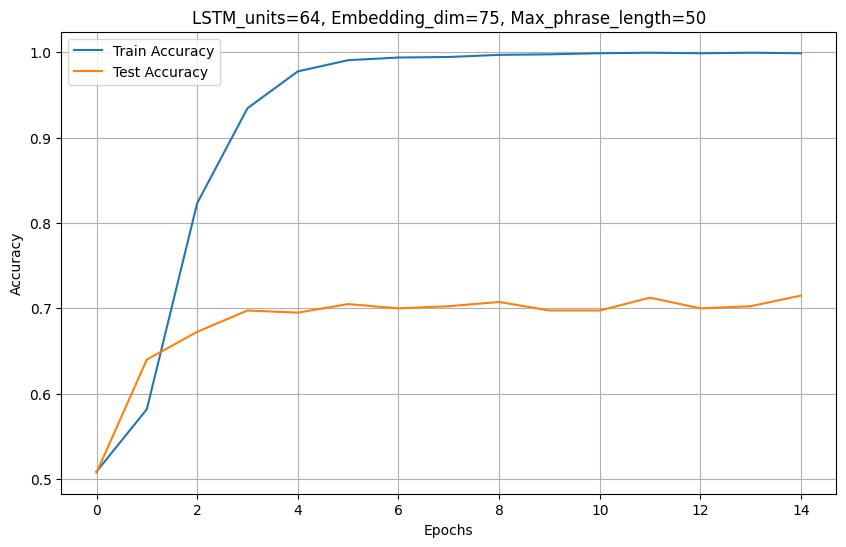

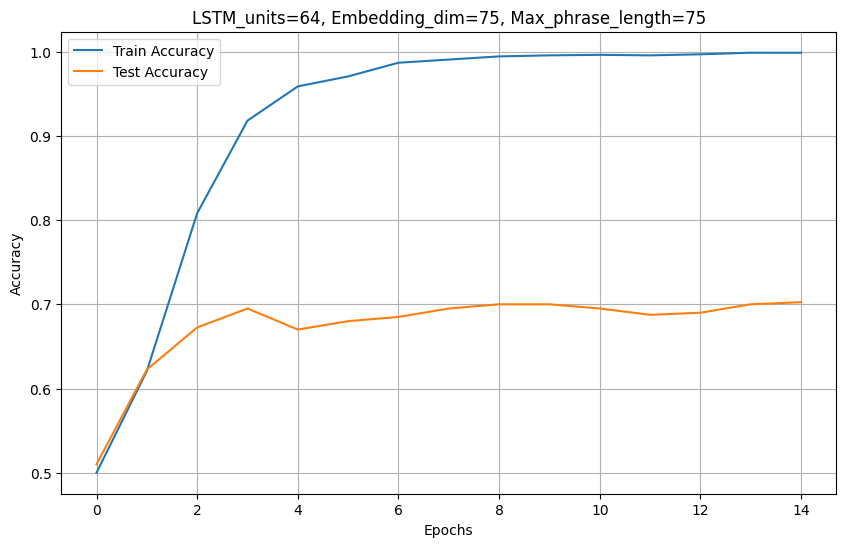

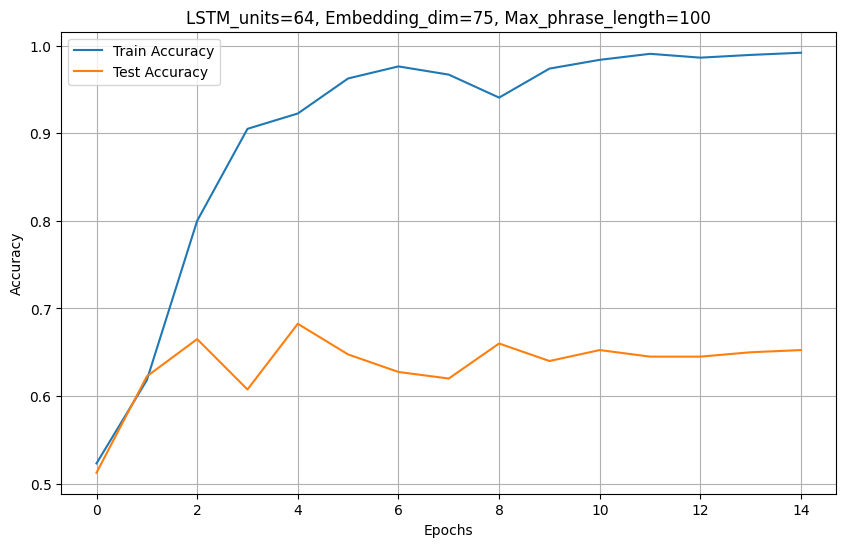

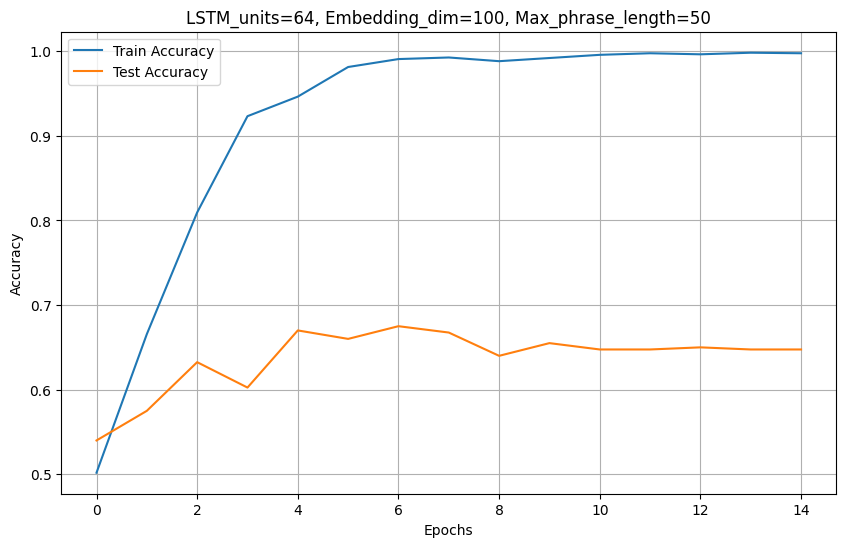

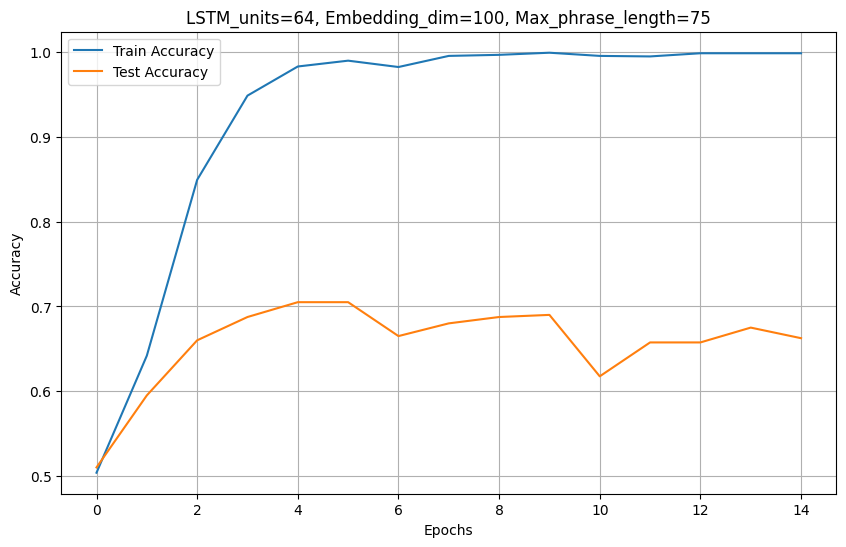

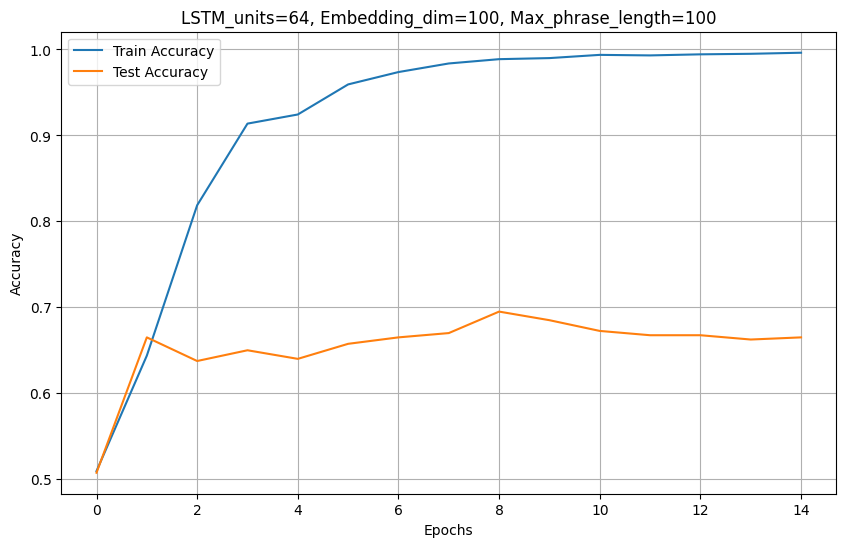

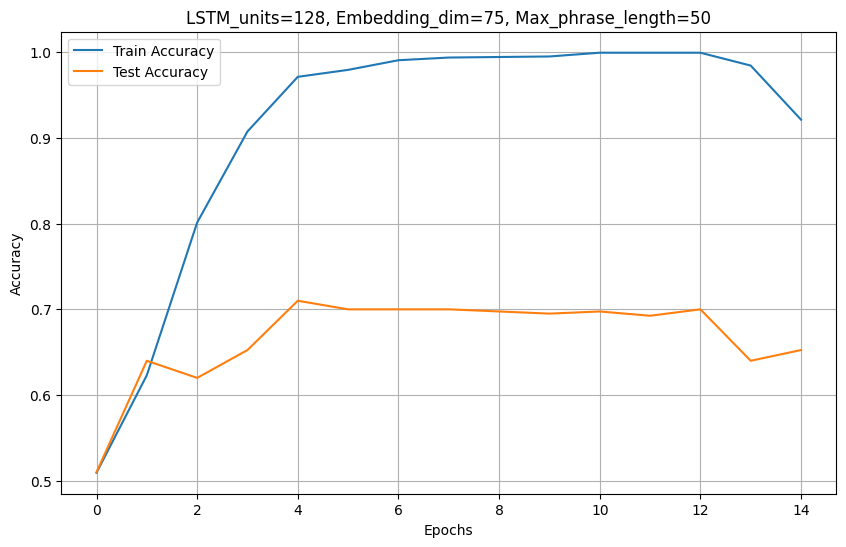

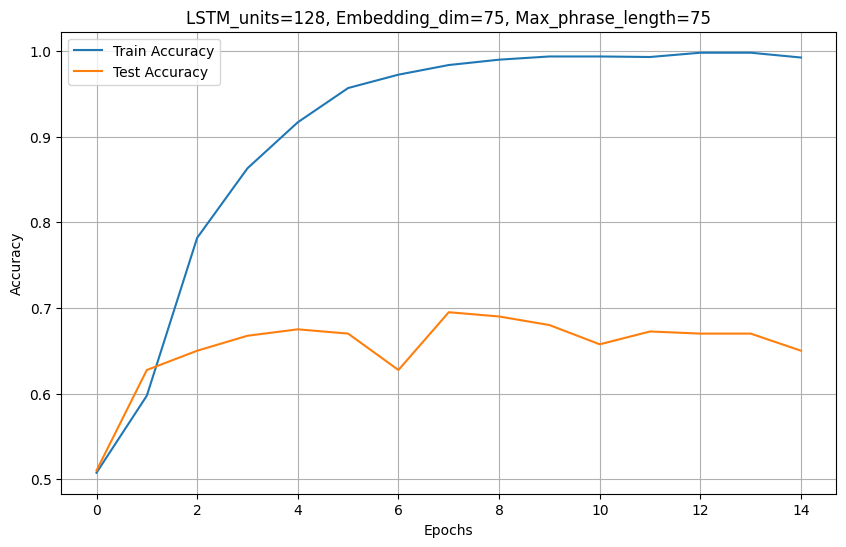

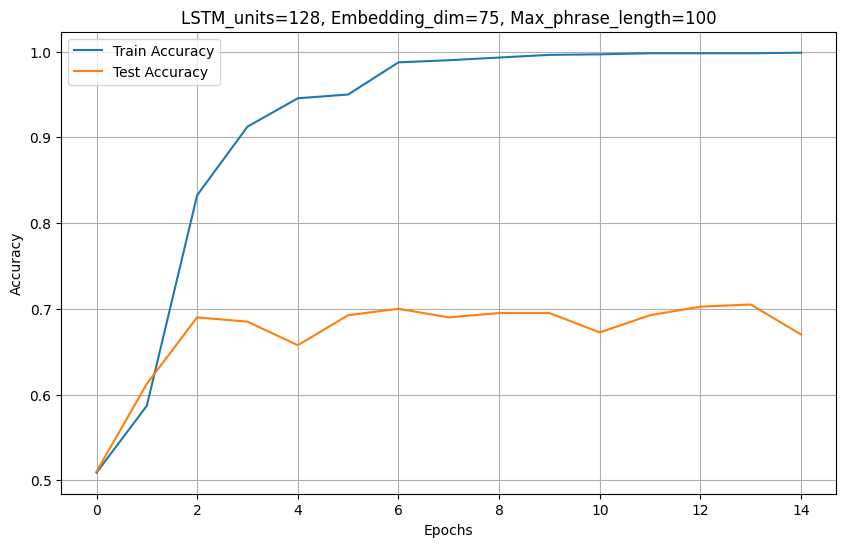

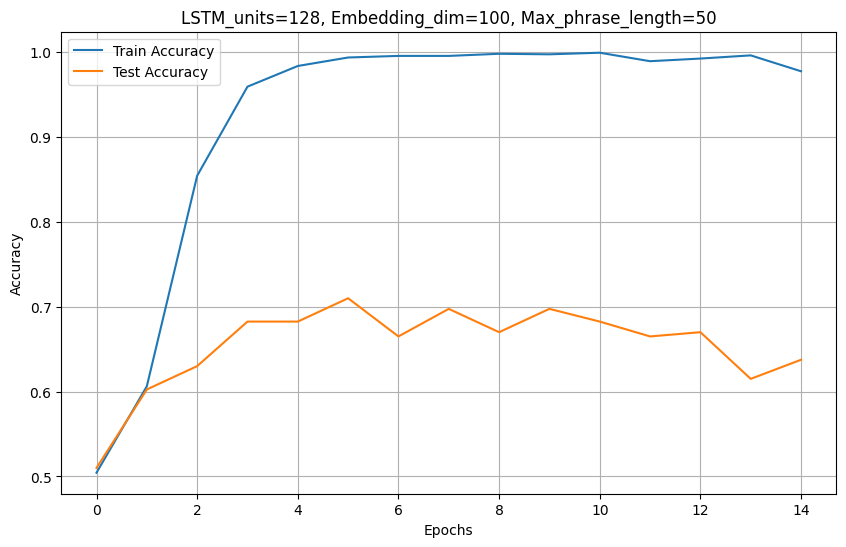

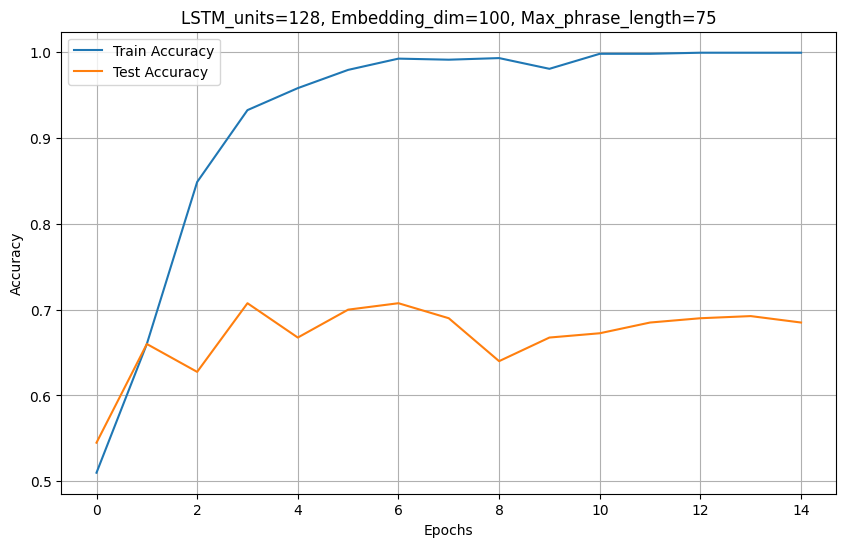

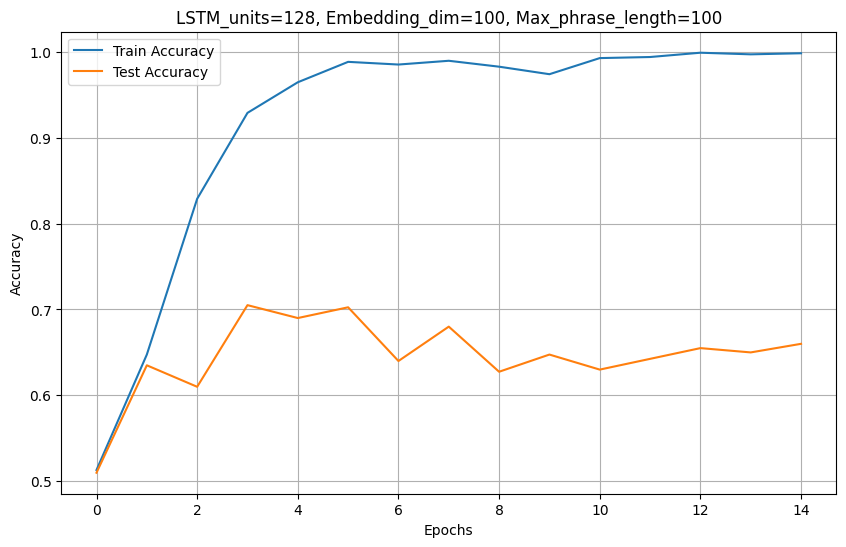

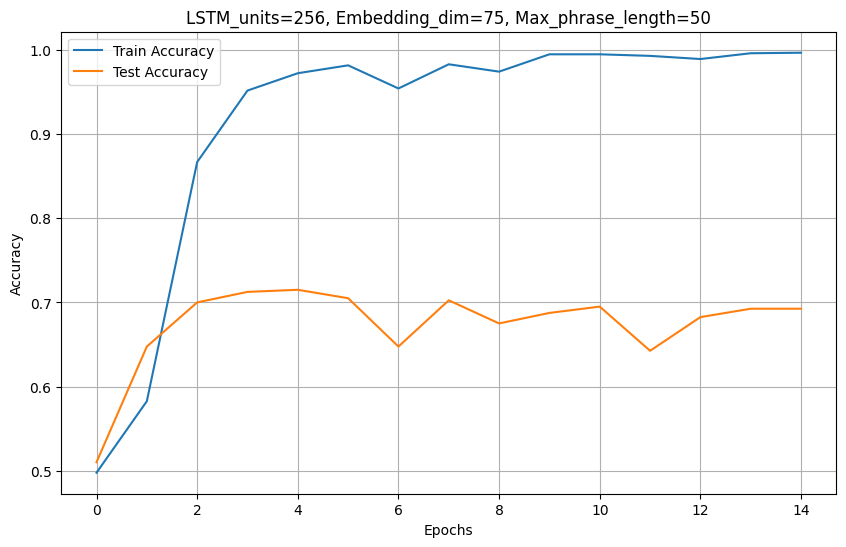

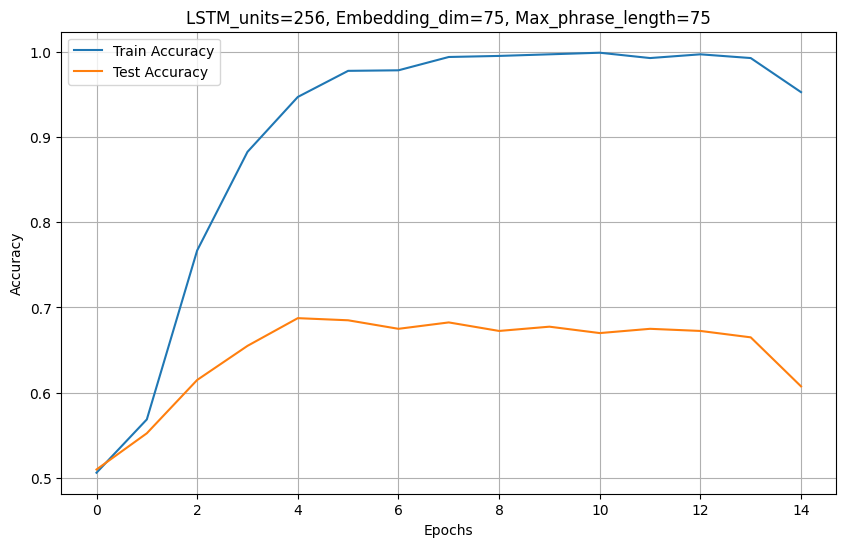

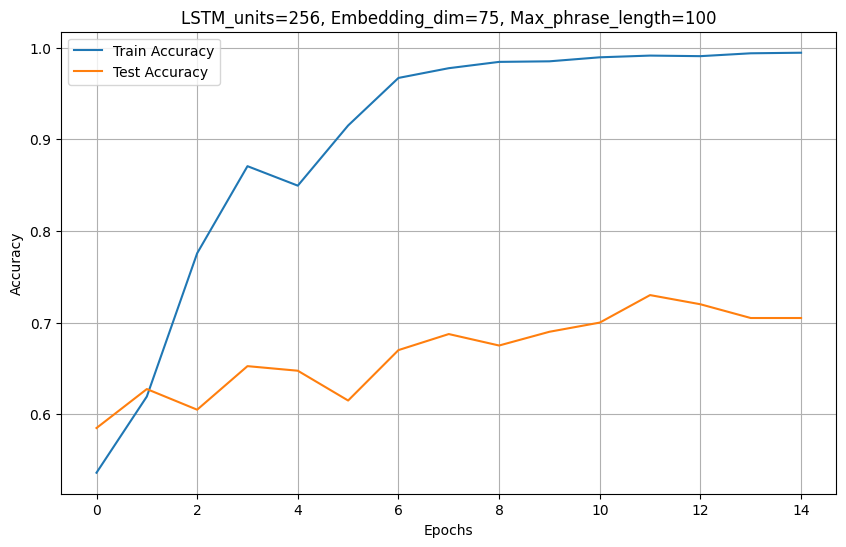

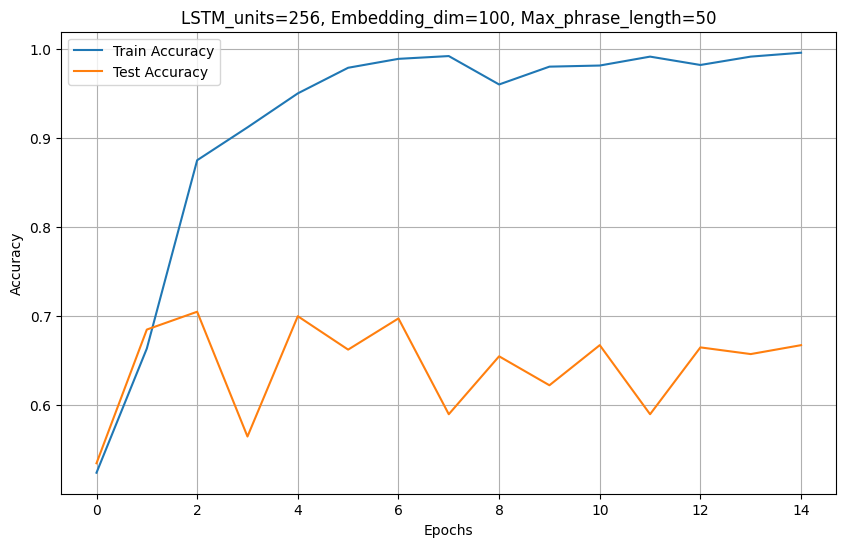

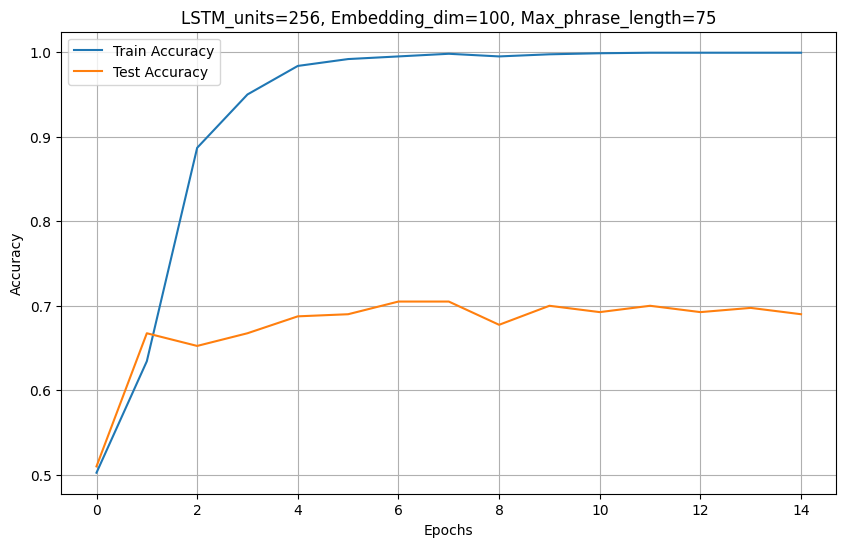

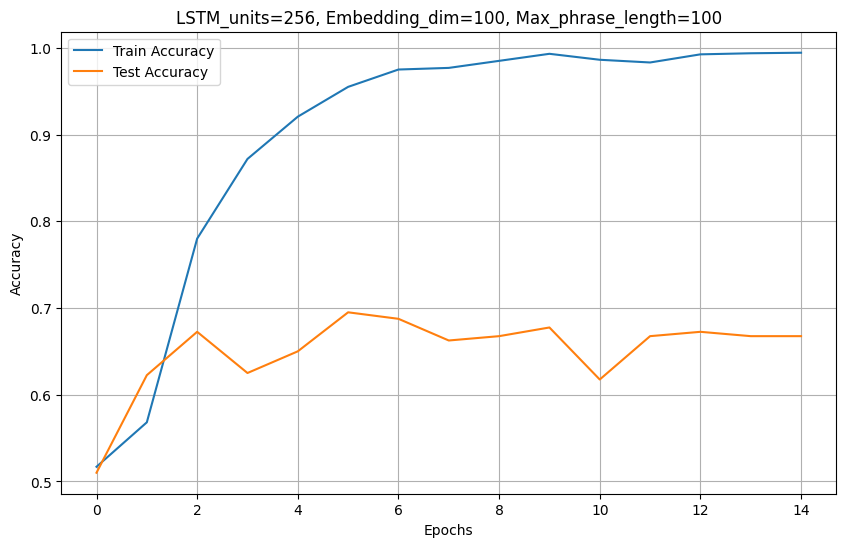

Total execution time: 301.84 seconds.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time  # For timing the evaluation
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Measure the start time for training
overall_start_time = time.time()


# Constants
max_number_words = 50000  # Vocabulary size
epochs = 15  # Fixed at 15 as per instructions
batch_size = 64  # Fixed

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/MovieReviews.csv')

# Tokenization and padding
tokenizer = Tokenizer(num_words=max_number_words, lower=True)
tokenizer.fit_on_texts(df['text'].values)
x = tokenizer.texts_to_sequences(df['text'].values)
y = pd.get_dummies(df['label']).values

# Configurations to iterate through
configurations = [
    (64, 75, 50), (64, 75, 75), (64, 75, 100),
    (64, 100, 50), (64, 100, 75), (64, 100, 100),
    (128, 75, 50), (128, 75, 75), (128, 75, 100),
    (128, 100, 50), (128, 100, 75), (128, 100, 100),
    (256, 75, 50), (256, 75, 75), (256, 75, 100),
    (256, 100, 50), (256, 100, 75), (256, 100, 100)
]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Dictionary to store results
results = {}

for LSTM_units, embedding_dim, max_phrase_length in configurations:
    # Pad sequences to match max_phrase_length
    x_train_padded = pad_sequences(x_train, maxlen=max_phrase_length)
    x_test_padded = pad_sequences(x_test, maxlen=max_phrase_length)

    # Build the model
    model = Sequential([
        Embedding(input_dim=max_number_words, output_dim=embedding_dim, input_length=max_phrase_length),
        SpatialDropout1D(0.1),
        LSTM(units=LSTM_units, activation='relu', dropout=0.2, recurrent_dropout=0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        x_train_padded, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(x_test_padded, y_test),
        verbose=0  # Suppress verbose output for multiple configurations
    )

    # Evaluate the model
    start_time = time.time()
    test_loss, test_acc = model.evaluate(x_test_padded, y_test, verbose=2)
    evaluation_time = time.time() - start_time

    # Store results
    results[(LSTM_units, embedding_dim, max_phrase_length)] = {
        'history': history.history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'evaluation_time': evaluation_time
    }

    # Print evaluation details
    print(f"Configuration: LSTM_units={LSTM_units}, Embedding_dim={embedding_dim}, Max_phrase_length={max_phrase_length}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Evaluation Time: {evaluation_time:.2f} seconds\n")

# Plot results
for config, result in results.items():
    history = result['history']
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Test Accuracy')
    plt.title(f"LSTM_units={config[0]}, Embedding_dim={config[1]}, Max_phrase_length={config[2]}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Calculate and print overall execution duration
overall_evaluation_time = time.time() - overall_start_time
print(f"Total execution time: {overall_evaluation_time:.2f} seconds.")